# API Code to download Sentinel Hub Images

## Requirements

- To run the code you need to have an api key from Sentinel Hub.

## How to run the code?

Load the libraries, modify the variable place and when and execute the code.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import xml.etree.ElementTree as ET
import pickle
import glob
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import datetime as dt

# Data handling and visualization
import matplotlib.pyplot as plt
import numpy as np

# Geospatial libraries
import pyproj
from shapely.geometry import box
from shapely.ops import transform

# Sentinel Hub API
from sentinelhub import CRS, BBox, DataCollection, MimeType, SentinelHubRequest, SHConfig, generate_evalscript

# Cloud detection (optional)
from s2cloudless import S2PixelCloudDetector

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
PLACE = "usa2"
WHEN = "pre" # Options: 'pre', 'post'
DATA_FOLDER_PKL = os.path.join(os.getcwd(), 'data_pkl')
DATA_FOLDER = os.path.join(os.getcwd(), 'data')
XML_FOLDER_PATH = os.path.join(os.getcwd(), 'testing/copied_xml_files')

In [3]:
# Configuration Setup for Sentinel Hub API

# Load credentials from environment variables
CLIENT_ID = os.getenv('CLIENT_ID', None)
CLIENT_SECRET = os.getenv('CLIENT_SECRET', None)

# Initialize Sentinel Hub configuration
config = SHConfig()

# Set credentials if available
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
    print("Sentinel Hub credentials configured successfully!")
    print(f"Client ID: {CLIENT_ID[:8]}...")
else:
    print("   Sentinel Hub credentials not found in environment variables")
    print("   Set CLIENT_ID and CLIENT_SECRET in your .env file to use the API")
    print("   You can still use the metadata extraction functionality")

print("\nConfiguration ready!")

Sentinel Hub credentials configured successfully!
Client ID: 0c3483a3...

Configuration ready!


In [4]:
class MetadataExtractor:
    """
    A robust class to extract essential metadata from Sentinel-2 XML files
    for use with Sentinel Hub API
    """
    
    def __init__(self, xml_folder_path: str):
        """
        Initialize the MetadataExtractor
        
        Args:
            xml_folder_path (str): Path to the folder containing XML files
        """
        self.xml_folder_path = Path(xml_folder_path)
        self.metadata_cache = {}
    

    def extract_geospatial_metadata(self, country_id, when='pre', resolution=10):
        """
        Extract geospatial metadata from XML files.
        
        Args:
            country_id (str): Country identifier
            pkl_path (str): Path to the XML file or directory
            when (str): Time period identifier ('pre', 'post')
            resolution (int): Spatial resolution in meters
        
        Returns:
            dict: Extracted metadata dictionary
        """
        
        xml_file = self.xml_folder_path / f"{country_id}_{when}_inspire.xml"
        
        # Check if the XML file exists
        if not xml_file.exists():
            raise FileNotFoundError(f"XML file not found: {xml_file}")
        
        print(f"Extracting metadata from: {xml_file}")
        
        # Parse XML
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Namespaces
        ns = {
            'gmd': 'http://www.isotc211.org/2005/gmd',
            'gco': 'http://www.isotc211.org/2005/gco',
            'gml': 'http://www.opengis.net/gml'
        }
        
        try:
            # Extract product identification
            title_elem = root.find('.//gmd:title/gco:CharacterString', ns)
            title = title_elem.text if title_elem is not None else "Unknown"
            
            # Extract geographic coordinates
            west_elem = root.find('.//gmd:westBoundLongitude/gco:Decimal', ns)
            east_elem = root.find('.//gmd:eastBoundLongitude/gco:Decimal', ns)
            south_elem = root.find('.//gmd:southBoundLatitude/gco:Decimal', ns)
            north_elem = root.find('.//gmd:northBoundLatitude/gco:Decimal', ns)
            
            west = float(west_elem.text) if west_elem is not None else None
            east = float(east_elem.text) if east_elem is not None else None
            south = float(south_elem.text) if south_elem is not None else None
            north = float(north_elem.text) if north_elem is not None else None
            
            # Extract temporal information
            begin_elem = root.find('.//gml:beginPosition', ns)
            end_elem = root.find('.//gml:endPosition', ns)
            
            begin_time = begin_elem.text if begin_elem is not None else None
            end_time = end_elem.text if end_elem is not None else None
            
            # Extract spatial resolution
            resolution_elem = root.find('.//gmd:denominator/gco:Integer', ns)
            spatial_resolution = int(resolution_elem.text) if resolution_elem is not None else resolution
            
            # Extract coordinate reference system
            crs_elem = root.find('.//gmd:code/gco:CharacterString', ns)
            crs_code = crs_elem.text if crs_elem is not None else "Unknown"
            
            # Extract keywords
            keywords = []
            for keyword in root.findall('.//gmd:keyword/gco:CharacterString', ns):
                if keyword.text:
                    keywords.append(keyword.text)
            
            # Extract organization info
            org_elem = root.find('.//gmd:organisationName/gco:CharacterString', ns)
            email_elem = root.find('.//gmd:electronicMailAddress/gco:CharacterString', ns)
            
            organization = org_elem.text if org_elem is not None else "Unknown"
            email = email_elem.text if email_elem is not None else "Unknown"
            
            # Extract creation date
            date_elem = root.find('.//gmd:date/gmd:CI_Date/gmd:date/gco:Date', ns)
            creation_date = date_elem.text if date_elem is not None else None
            
        except Exception as e:
            print(f"Warning: Error extracting some metadata: {e}")
            # Provide default values if extraction fails
            title = "Unknown"
            west = east = south = north = None
            begin_time = end_time = None
            spatial_resolution = resolution
            crs_code = "Unknown"
            keywords = []
            organization = email = "Unknown"
            creation_date = None
        
        # Build metadata dictionary
        metadata = {
            'country_id': country_id,
            'time_period': when,
            'product_info': {
                'title': title,
                'creation_date': creation_date,
                'file_path': xml_file
            },
            'spatial_extent': {
                'west_bound': west,
                'east_bound': east,
                'south_bound': south,
                'north_bound': north,
                'center_lat': (north + south) / 2 if north and south else None,
                'center_lon': (east + west) / 2 if east and west else None
            },
            'temporal_extent': {
                'start_time': begin_time,
                'end_time': end_time
            },
            'technical_specs': {
                'spatial_resolution': spatial_resolution,
                'crs_code': crs_code,
                'keywords': keywords
            },
            'contact_info': {
                'organization': organization,
                'email': email
            }
        }
        
        return metadata

print(f"Using XML folder path: {XML_FOLDER_PATH}")
extractor = MetadataExtractor(XML_FOLDER_PATH)

print("MetadataExtractor initialized successfully!")

Using XML folder path: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files
MetadataExtractor initialized successfully!


In [5]:
# Example usage
try:
    metadata = extractor.extract_geospatial_metadata(country_id=PLACE, when=WHEN, resolution=10)
    print("Metadata extracted successfully!")
    print(metadata)
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/usa2_pre_inspire.xml
Metadata extracted successfully!
{'country_id': 'usa2', 'time_period': 'pre', 'product_info': {'title': 'S2A_MSIL1C_20240904T184101_N0511_R027_T11SMT_20240905T000132.SAFE', 'creation_date': '2014-01-01', 'file_path': PosixPath('/Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/usa2_pre_inspire.xml')}, 'spatial_extent': {'west_bound': -118.08758328379659, 'east_bound': -116.89388597356326, 'south_bound': 33.34670729944278, 'north_bound': 34.34161747897296, 'center_lat': 33.84416238920787, 'center_lon': -117.49073462867992}, 'temporal_extent': {'start_time': '2024-09-04T18:40:56', 'end_time': '2024-09-04T18:46:31'}, 'technical_specs': {'spatial_resolution': 20, 'crs_code': 'http://www.opengis.net/def/crs/EPSG/0/4936', 'keywords': ['Orthoimagery', 'Land cover', 'Geographical names', 'data set series', 'processi

# API Extraction Function

In [6]:
def api_image_extraction_tiled(extractor, country_id, when='pre', resolution=10, max_pixels=2500):
    """
    Extract image data from Sentinel Hub API in tiles to handle large images.
    
    Args:
        extractor: MetadataExtractor instance
        country_id (str): Country identifier
        when (str): Time period identifier ('pre', 'post')
        resolution (int): Spatial resolution in meters
        max_pixels (int): Maximum pixels per dimension for each tile
    
    Returns:
        dict: Image data dictionary with tiles
    """
    
    # Extract metadata
    metadata = extractor.extract_geospatial_metadata(country_id, when, resolution)
    
    if not metadata:
        raise ValueError(f"No metadata found for country_id: {country_id}, when: {when}")
    
    # Calculate number of tiles needed
    total_pixels = 10980  # Your original size
    tiles_per_side = int(np.ceil(total_pixels / max_pixels))
    print(f"Dividing image into {tiles_per_side}x{tiles_per_side} = {tiles_per_side**2} tiles")
    
    # Original bounding box
    west = metadata['spatial_extent']['west_bound']
    south = metadata['spatial_extent']['south_bound'] 
    east = metadata['spatial_extent']['east_bound']
    north = metadata['spatial_extent']['north_bound']
    
    # Calculate tile dimensions in geographic coordinates
    tile_width = (east - west) / tiles_per_side
    tile_height = (north - south) / tiles_per_side
    print(f"Tile dimensions: {tile_width:.6f}° longitude, {tile_height:.6f}° latitude")
    
    # Time range
    time_range = (metadata['temporal_extent']['start_time'], metadata['temporal_extent']['end_time'])
    print(f"Time range: {time_range}")

    data_collection = DataCollection.SENTINEL2_L1C
    
    evalscript = generate_evalscript(
        data_collection=data_collection,
        meta_bands=["dataMask"],
        merged_bands_output="bands",
        prioritize_dn=False,
    )
    
    tiles_data = []
    tile_info = []
    successful_tiles = 0
    
    # Extract each tile
    for row in range(tiles_per_side):
        for col in range(tiles_per_side):
            print(f"Processing tile {row+1},{col+1} of {tiles_per_side}x{tiles_per_side}")

            # Calculate tile bounds
            tile_west = west + col * tile_width
            tile_east = west + (col + 1) * tile_width
            tile_south = south + row * tile_height
            tile_north = south + (row + 1) * tile_height
            
            # Create bbox for this tile
            tile_bbox = BBox(bbox=[tile_west, tile_south, tile_east, tile_north], crs=CRS.WGS84)
            print(f"  Tile bounding box: {tile_bbox}")
            
            request = SentinelHubRequest(
                evalscript=evalscript,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=data_collection,
                        time_interval=time_range
                    )
                ],
                responses=[
                    SentinelHubRequest.output_response('bands', MimeType.TIFF),
                    SentinelHubRequest.output_response('dataMask', MimeType.TIFF),
                ],
                bbox=tile_bbox,
                size=(max_pixels, max_pixels),
                config=config
            ) 
            
            try:
                # Get tile data
                tile_data = request.get_data()
                tiles_data.append(tile_data)
                successful_tiles += 1

                # Save tile data to disk
                tile_filename = f"{country_id}_{when}_tile_{row+1}_{col+1}.pkl"
                tile_filepath = os.path.join(DATA_FOLDER, tile_filename)

                with open(tile_filepath, 'wb') as f:
                    pickle.dump(tile_data, f)

                print(f"  ✓ Tile {row+1},{col+1} saved to {tile_filepath}")
                
                # Store tile info
                tile_info.append({
                    'row': row,
                    'col': col,
                    'bbox': [tile_west, tile_south, tile_east, tile_north],
                    'size': (max_pixels, max_pixels),
                    'success': True
                })
                
                print(f"  ✓ Tile {row+1},{col+1} extracted successfully")
                
            except Exception as e:
                print(f"  ✗ Error processing tile {row+1},{col+1}: {e}")
                tiles_data.append(None)
                tile_info.append({
                    'row': row,
                    'col': col,
                    'bbox': [tile_west, tile_south, tile_east, tile_north],
                    'size': (max_pixels, max_pixels),
                    'success': False,
                    'error': str(e)
                })
    
    print(f"\nSummary: {successful_tiles}/{tiles_per_side**2} tiles extracted successfully")
    
    return {
        'metadata': metadata,
        'tiles_data': tiles_data,
        'tile_info': tile_info,
        'grid_size': (tiles_per_side, tiles_per_side),
        'total_tiles': tiles_per_side**2,
        'successful_tiles': successful_tiles
    }

def reconstruct_image_from_tiles(tiles_result, band_index=0):
    """
    Reconstruct the full image from tiles.
    
    Args:
        tiles_result: Result from api_image_extraction_tiled
        band_index: Which band to reconstruct (0=Red, 1=Green, 2=Blue, 3=NIR)
    
    Returns:
        numpy.ndarray: Reconstructed image
    """
    tiles_data = tiles_result['tiles_data']
    grid_size = tiles_result['grid_size']
    tiles_per_side = grid_size[0]
    
    # Get tile dimensions from first valid tile
    tile_shape = None
    for tile_data in tiles_data:
        if tile_data is not None and len(tile_data) > 0:
            tile_shape = tile_data[band_index].shape
            break
    
    if tile_shape is None:
        raise ValueError("No valid tile data found")
    
    # Initialize full image array
    full_height = tile_shape[0] * tiles_per_side
    full_width = tile_shape[1] * tiles_per_side
    
    if len(tile_shape) == 3:  # RGB image
        full_image = np.zeros((full_height, full_width, tile_shape[2]), dtype=np.uint16)
    else:  # Grayscale
        full_image = np.zeros((full_height, full_width), dtype=np.uint16)
    
    # Place each tile in the correct position
    for i, tile_data in enumerate(tiles_data):
        if tile_data is not None and len(tile_data) > 0:
            row = i // tiles_per_side
            col = i % tiles_per_side
            
            start_row = row * tile_shape[0]
            end_row = start_row + tile_shape[0]
            start_col = col * tile_shape[1]
            end_col = start_col + tile_shape[1]
            
            full_image[start_row:end_row, start_col:end_col] = tile_data[band_index]
    
    return full_image

def create_rgb_composite(tiles_result, enhance=True):
    """
    Create an RGB composite from the tiles.
    
    Args:
        tiles_result: Result from api_image_extraction_tiled
        enhance: Whether to enhance the image for better visualization
    
    Returns:
        numpy.ndarray: RGB composite image
    """
    # Get individual bands (R, G, B)
    red_band = reconstruct_image_from_tiles(tiles_result, band_index=0)
    green_band = reconstruct_image_from_tiles(tiles_result, band_index=1) 
    blue_band = reconstruct_image_from_tiles(tiles_result, band_index=2)
    
    # Stack bands
    rgb_image = np.stack([red_band, green_band, blue_band], axis=2)
    
    if enhance:
        # Normalize to 0-1 range
        rgb_image = rgb_image.astype(np.float32)
        
        # Apply percentile stretch for better visualization
        for i in range(3):
            band = rgb_image[:, :, i]
            p2, p98 = np.percentile(band[band > 0], [2, 98])
            rgb_image[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
    
    return rgb_image

In [ ]:
# Try to extract image data using the improved tiled approach
try:
    result = api_image_extraction_tiled(extractor, country_id=PLACE, when=WHEN, resolution=10, max_pixels=2500)
    metadata = result['metadata']
    tiles_data = result['tiles_data']
    tile_info = result['tile_info']
    
    print("Image data extracted successfully!")
        
except Exception as e:
    print(f"An error occurred during image extraction: {e}")
    import traceback
    traceback.print_exc()

# Save result in DATA_FOLDER
output_file = os.path.join(DATA_FOLDER_PKL, f"{metadata['country_id']}_{metadata['time_period']}_tiles_data.pkl")
os.makedirs(DATA_FOLDER_PKL, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)

# Saving raw data
try:
    with open(output_file, 'wb') as f:
        pickle.dump(result, f)
    print(f"Data saved successfully to {output_file}")
except Exception as e:
    print(f"Error saving data: {e}")
    import traceback
    traceback.print_exc()

Extracting metadata from: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/usa2_pre_inspire.xml
Dividing image into 5x5 = 25 tiles
Tile dimensions: 0.238739° longitude, 0.198982° latitude
Time range: ('2024-09-04T18:40:56', '2024-09-04T18:46:31')
Processing tile 1,1 of 5x5
  Tile bounding box: -118.08758328379659,33.34670729944278,-117.84884382174992,33.54568933534881


/var/folders/mr/n19psg616pb4dyc16wbyn8yc0000gn/T/ipykernel_82331/1318989119.py:68: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(f"  Tile bounding box: {tile_bbox}")


In [ ]:
metadata = result['metadata']
print(f"Metadata saved in: {metadata['product_info']['file_path']}")
print(f"Extracted metadata: {metadata}")

images = result['tiles_data']
print(f"Number of images extracted: {len(images)}")
print(f"Tile info: {result['tile_info'][:5]}")  # Show first 5 tile info entries
print(f"Grid size: {result['grid_size']}")
print(f"Total tiles: {result['total_tiles']}")
print(f"Successful tiles: {result['successful_tiles']}")

Metadata saved in: /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml
Extracted metadata: {'country_id': 'chile', 'time_period': 'post', 'product_info': {'title': 'S2A_MSIL1C_20240212T143741_N0510_R096_T19HBD_20240212T175807.SAFE', 'creation_date': '2014-01-01', 'file_path': PosixPath('/Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/testing/copied_xml_files/chile_post_inspire.xml')}, 'spatial_extent': {'west_bound': -72.22879766581241, 'east_bound': -71.0252199246292, 'south_bound': -33.510854103056296, 'north_bound': -32.49681353241886, 'center_lat': -33.00383381773758, 'center_lon': -71.6270087952208}, 'temporal_extent': {'start_time': '2024-02-12T14:44:10', 'end_time': '2024-02-12T14:56:40'}, 'technical_specs': {'spatial_resolution': 20, 'crs_code': 'http://www.opengis.net/def/crs/EPSG/0/4936', 'keywords': ['Orthoimagery', 'Land cover', 'Geographical names', 'data set series', 'processing']}, 'contact

In [ ]:
image_0 = images[0][0]["bands.tif"]
image_1 = images[1][0]["bands.tif"]
image_2 = images[2][0]["bands.tif"]
image_3 = images[3][0]["bands.tif"]
image_4 = images[4][0]["bands.tif"]
image_5 = images[5][0]["bands.tif"]
image_6 = images[6][0]["bands.tif"]
image_7 = images[7][0]["bands.tif"]
image_8 = images[8][0]["bands.tif"]
image_9 = images[9][0]["bands.tif"]
image_10 = images[10][0]["bands.tif"]
image_11 = images[11][0]["bands.tif"]
image_12 = images[12][0]["bands.tif"]
image_13 = images[13][0]["bands.tif"]
image_14 = images[14][0]["bands.tif"]
image_15 = images[15][0]["bands.tif"]
image_16 = images[16][0]["bands.tif"]
image_17 = images[17][0]["bands.tif"]
image_18 = images[18][0]["bands.tif"]
image_19 = images[19][0]["bands.tif"]
image_20 = images[20][0]["bands.tif"]
image_21 = images[21][0]["bands.tif"]
image_22 = images[22][0]["bands.tif"]
image_23 = images[23][0]["bands.tif"]
image_24 = images[24][0]["bands.tif"]

mix = np.vstack((np.hstack((image_20, image_21, image_22, image_23, image_24)),
                 np.hstack((image_15, image_16, image_17, image_18, image_19)),
                 np.hstack((image_10, image_11, image_12, image_13, image_14)),
                 np.hstack((image_5, image_6, image_7, image_8, image_9)),
                 np.hstack((image_0, image_1, image_2, image_3, image_4))))

mix_output_file = os.path.join(DATA_FOLDER, f"{PLACE}_{WHEN}.npy")

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Load images from tim

image_1_path = os.path.join(DATA_FOLDER, f"{PLACE}_{WHEN}_tile_1_1.tif")


In [ ]:
# Save mix image
try:
    np.save(mix_output_file, mix)
    print(f"Mix image saved successfully to {mix_output_file}")
except Exception as e:
    print(f"Error saving mix image: {e}")
    import traceback
    traceback.print_exc()

Mix image saved successfully to /Users/diego/Documents/FirePrediction/data_pipeline/utils/data_api/data/chile_pre.npy


In [ ]:
def rgb_display(data):
    if data.max() > 255:
        data = np.clip(data / data.max() * 255, 0, 255).astype(np.uint8)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(data)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6248].


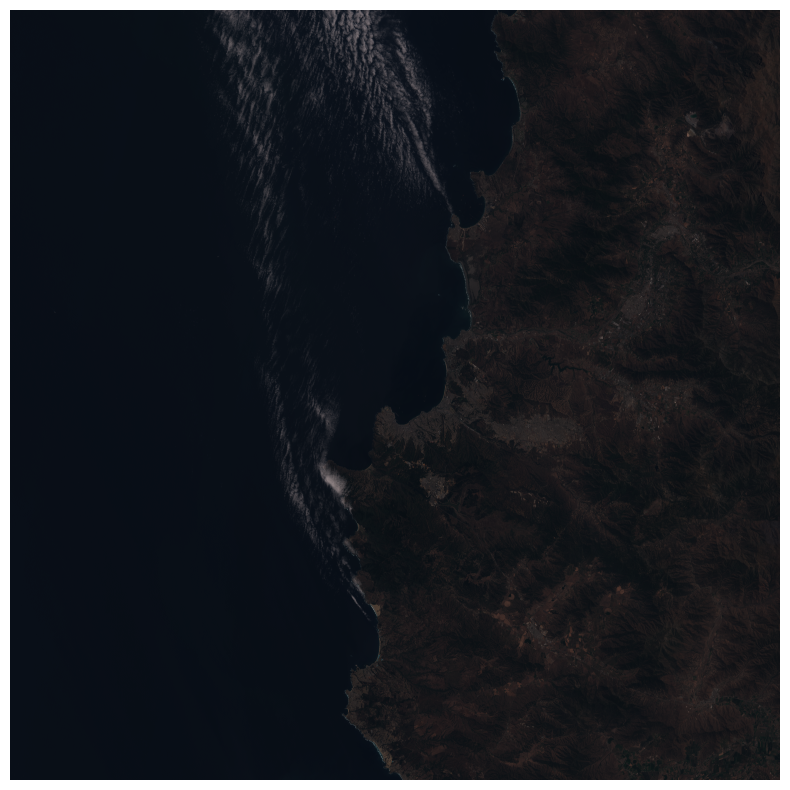

In [ ]:
rgb = mix[:,:,[3,2,1]]
rgb_display(rgb)